# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Заказчик этого исследования — сеть отелей «Как в гостях».**
<br>Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. <br>Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
<br>Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

***Описание данных***
<br>В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
- `Contract` — договор с юридическим лицом;
- `Group` — групповой заезд;
- `Transient` — не связано с договором или групповым заездом;
- `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
<br> `SC` — нет дополнительных опций;
<br> `BB` — включён завтрак;
<br> `HB` — включён завтрак и обед;
<br> `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

## Изучение данных

In [1]:
%pip install optuna
%pip install category_encoders

     |████████████████████████████████| 365 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 81 kB 2.0 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

Загружаем данные

In [4]:
data_train = pd.read_csv('/datasets/hotel_train.csv')
data_test = pd.read_csv('/datasets/hotel_test.csv')

Посмотрим на первые 5 строк

In [5]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


Просмотрим краткую информацию 

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [7]:
data_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Просмотрим на первые 5 строк 

In [8]:
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Просмотрим краткую информацию 

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [10]:
data_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


***Вывод:*** были загружены данные, в том числе проведен первычных анализ. Каждый из наборов данных содержит одинаковый набор признаков. В тренировочных данных 65229 наблюдений и 25 признаков, в тестовых данных 32412 наблюдений и также 25 признаков. 

## Предобработка и исследовательский анализ данных

Проверим наличие пропусков в тренировочных данных

In [11]:
data_train.isnull().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Проверим наличие явных дубликатов

In [12]:
data_train.duplicated().sum()

0

Проверим наличие пропусков в тестовых данных

In [13]:
data_test.isnull().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Проверим наличие явных дубликатов в тестовых данных

In [14]:
data_test.duplicated().sum()

0

Заменим тип данных в явно целочисленных столбцах

In [15]:
for column in ['adults', 'children', 'babies']:
    data_train[column] = data_train[column].astype('int')
    data_test[column] = data_test[column].astype('int')

Проверим, совпадают ли типы данных

In [16]:
data_train.dtypes == data_test.dtypes

id                                True
is_canceled                       True
lead_time                         True
arrival_date_year                 True
arrival_date_month                True
arrival_date_week_number          True
arrival_date_day_of_month         True
stays_in_weekend_nights           True
stays_in_week_nights              True
adults                            True
children                          True
babies                            True
meal                              True
country                           True
distribution_channel              True
is_repeated_guest                 True
previous_cancellations            True
previous_bookings_not_canceled    True
reserved_room_type                True
booking_changes                   True
days_in_waiting_list              True
customer_type                     True
required_car_parking_spaces       True
total_of_special_requests         True
total_nights                      True
dtype: bool

Проверим наличие неявных дубликатов в данных. Явно можем проверить наличие дубликатов в 'meal', так как изначально ясно, что должно быть 4 значения

In [17]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [18]:
data_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Удалим пробелы в значениях для избавления от неявных дубликатов

In [19]:
data_train['meal'] = data_train['meal'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

In [20]:
data_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [21]:
data_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [22]:
data_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [23]:
data_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [24]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [25]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()

In [26]:
data_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [27]:
data_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

Проверим целевой признак

In [28]:
data_train['is_canceled'].unique()

array([0, 1])

Проверим наличие аномальных значений в колонках

In [29]:
data_train['arrival_date_year'].unique()

array([2015, 2016])

In [30]:
data_train['arrival_date_day_of_month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [31]:
data_train['adults'].unique()

array([1, 2, 3, 4, 0])

In [32]:
print(data_train.loc[(data_train['adults'] == 0)]['adults'].count())

data_test.loc[(data_train['adults'] == 0)]['adults'].count()

166


72

Кажется странным, что в данных есть строки с 0 числом взрослых постояльцев. Однако таких данных относительно много в обоих наборах данных, кажется, это не ошибка, не будем удалять такие значения.

In [33]:
data_train['adults'].unique()

array([1, 2, 3, 4, 0])

In [34]:
data_train['babies'].unique()

array([ 0,  1,  2, 10,  9])

In [35]:
data_train.loc[(data_train['babies'] == 10) | (data_train['babies'] == 9)]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2,...,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1,...,0,0,0,A,1,0,Transient-Party,0,0,3


In [36]:
data_train = data_train[(data_train.babies != 10) & (data_train.babies != 9)]

In [37]:
data_train.babies.unique()

array([0, 1, 2])

In [38]:
data_train['required_car_parking_spaces'].unique()

array([0, 1, 2, 3])

In [39]:
data_train = data_train.drop('id', axis=1)
data_test = data_test.drop('id', axis=1)

Посмотрим на корреляцию с целевым признаком в тренировочных данных

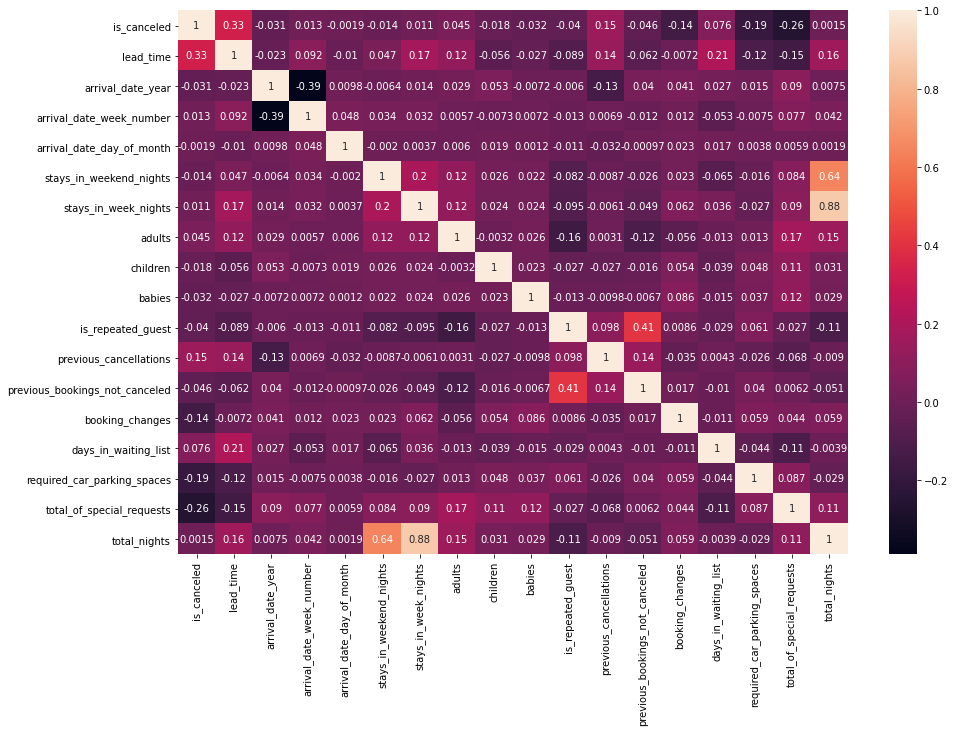

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(data_train.corr(), annot = True);

1. Больше всего в тренировочных данных заметна положительная корреляция среди столбца `load_time`

--- То есть, чем больше значения в этих столбцах, тем больше и вероятность отмены бронирования
1. Больше всего в тренировочных данных заметна отрицательная корреляция с `total_of_special_requests`

--- То есть, чем больше значения в этих столбцах, тем меньше вероятность отмены бронирования

Видим сильную корреляцию между `total_nights` и `stays_in_week_nights`. Удалим признак `stays_in_week_nights`.

In [41]:
data_train = data_train.drop('stays_in_week_nights', axis=1)
data_test = data_test.drop('stays_in_week_nights', axis=1)

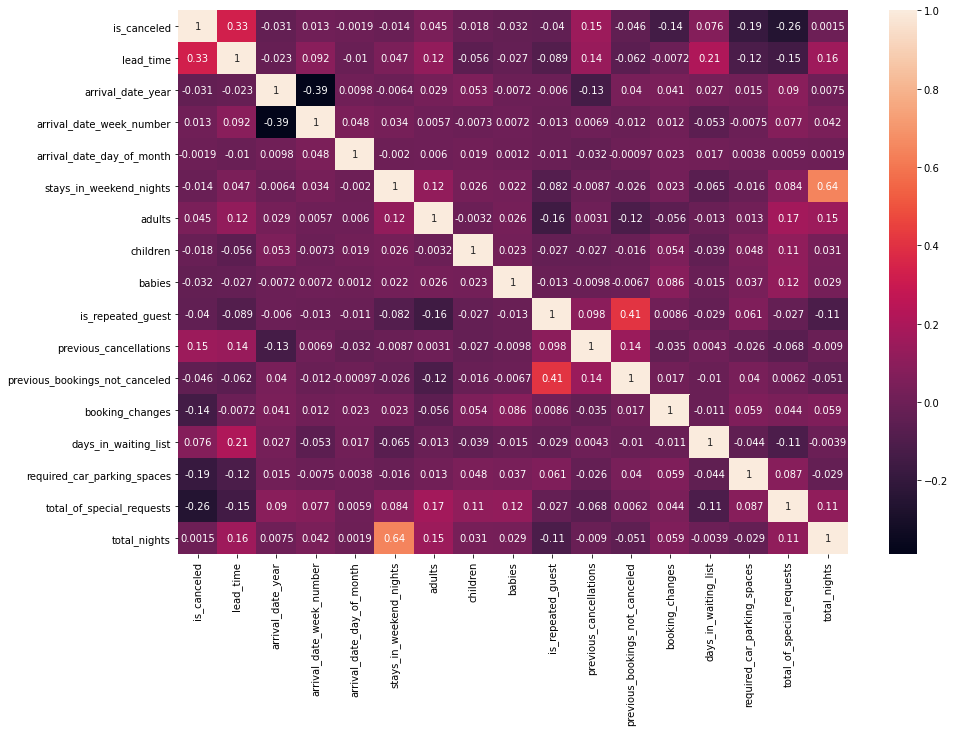

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(data_train.corr(), annot = True);

In [43]:
# определяем цветовую гамму и размер таблиц
colors = sns.color_palette('Set2')
sns.set(rc={'figure.figsize':(15, 5)}, palette=colors)

Посмотрим на распределение количественных тренировочных данных

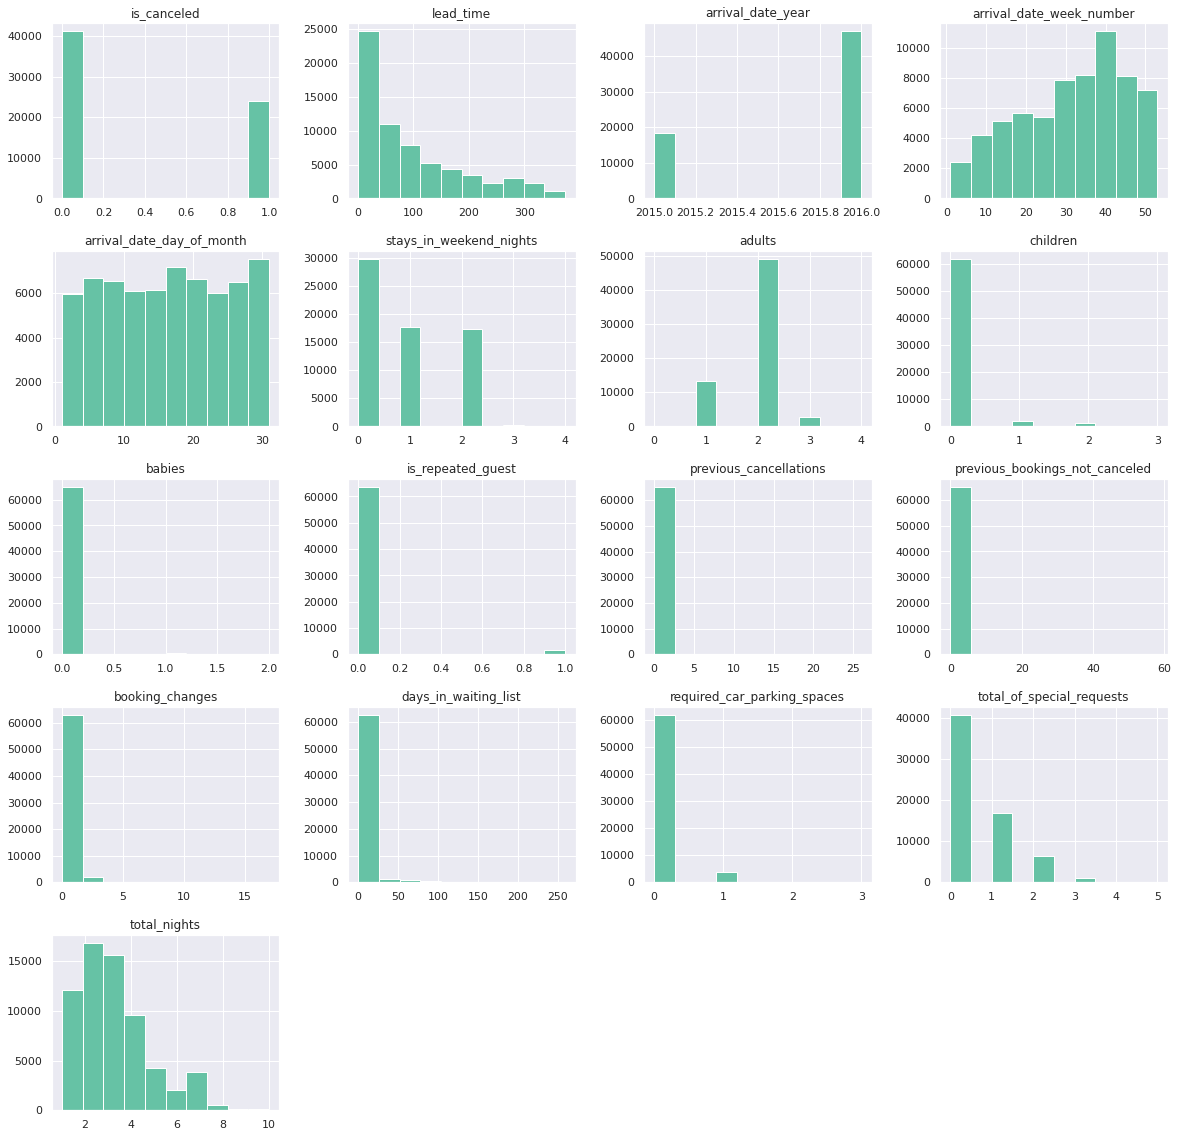

In [44]:
data_train.hist(figsize=(20,20));

Посмотрим на распределение количественных тестовых данных

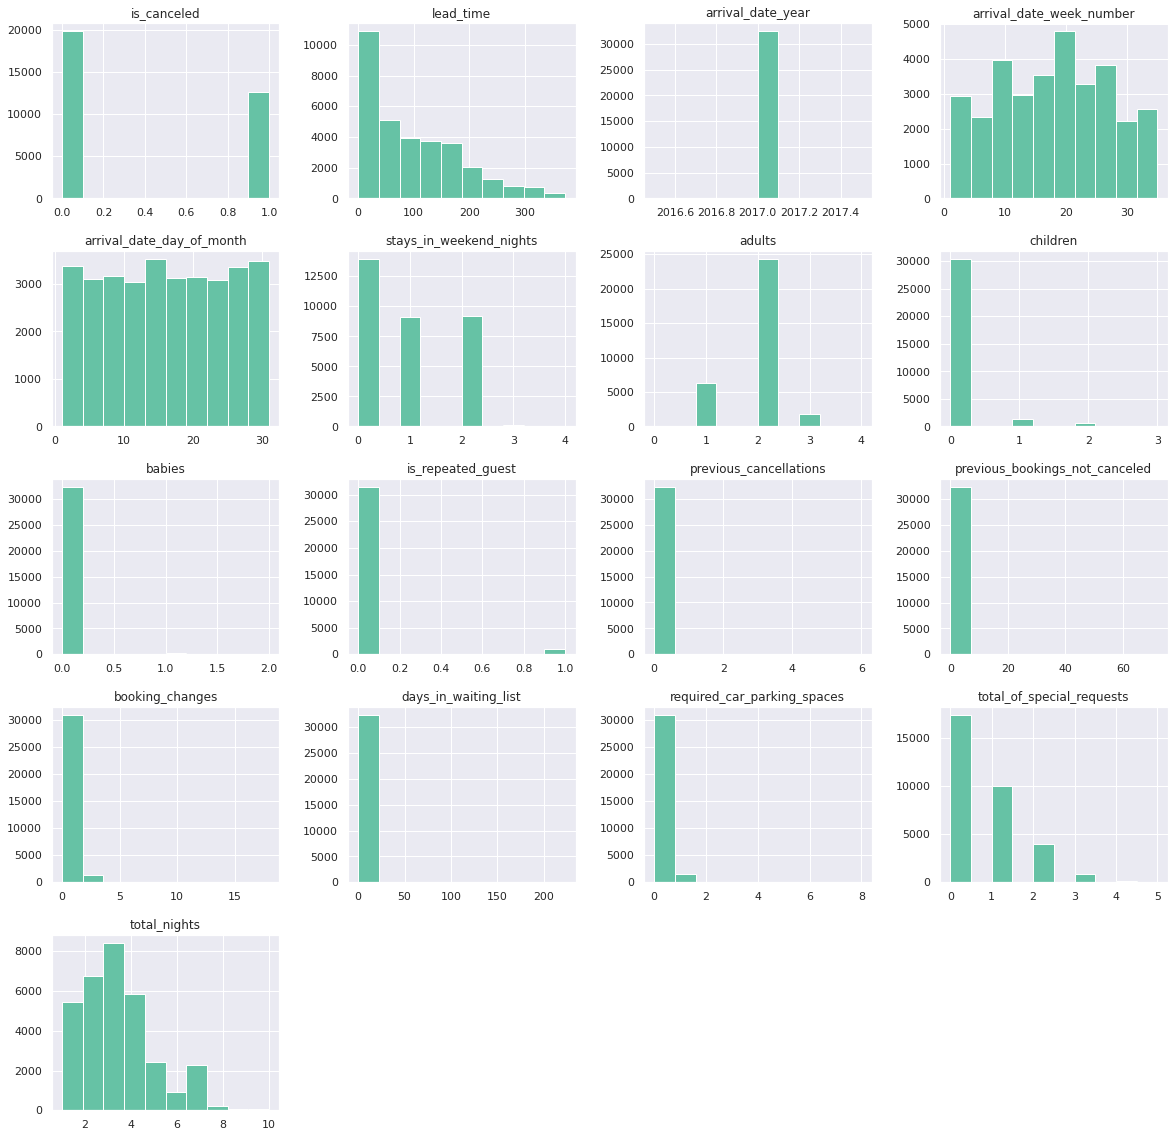

In [45]:
data_test.hist(figsize=(20,20));

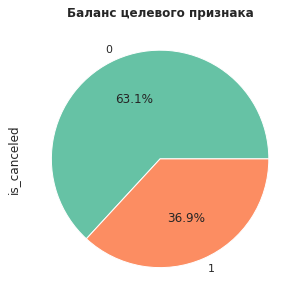

In [46]:
# посмотрим на баланс целевого признака в тренировочных данных
plt.figure(figsize=(8,5)) 
plt.title('Баланс целевого признака', fontweight='bold')
data_train['is_canceled'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

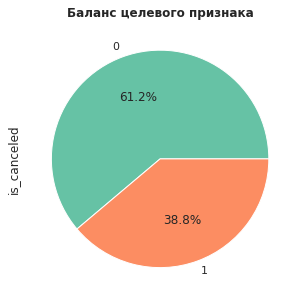

In [47]:
# посмотрим на баланс целевого признака в тестовых данных
plt.figure(figsize=(8,5)) 
plt.title('Баланс целевого признака', fontweight='bold')
data_test['is_canceled'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

Наблюдается дисбаланс целевого признака, доля отмены бронирования колеблется в районе 37-39% в обоих наборах данных.

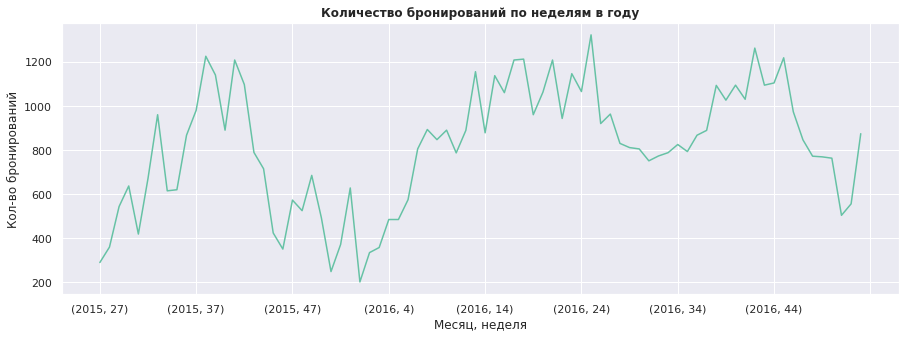

In [48]:
data_train.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                            values='is_canceled', aggfunc='count').plot(legend=None);
plt.xlabel('Месяц, неделя');
plt.ylabel('Кол-во бронирований');
plt.title(f'Количество бронирований по неделям в году', fontweight='bold');

Количество бронирований стабильно высокое в середине года, однако наблюдаются также сезонные повышения, в частности под Новый Год.

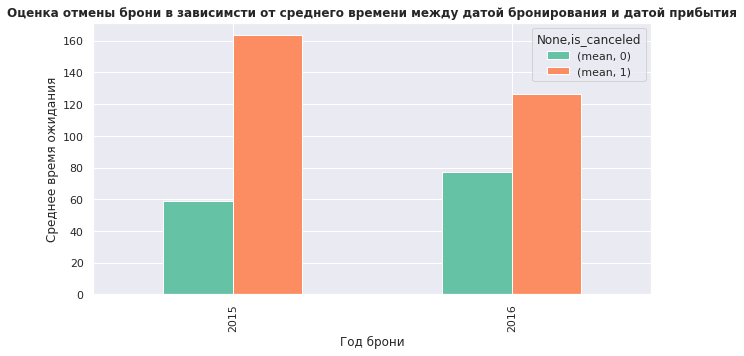

In [49]:
data_train.pivot_table(index='arrival_date_year', columns='is_canceled', values='lead_time', 
                       aggfunc=['mean']).plot(kind='bar', grid=True, figsize=(10,5));
plt.title(f'Оценка отмены брони в зависимсти от среднего времени между датой бронирования и датой прибытия', 
          fontweight='bold');
plt.xlabel('Год брони');
plt.ylabel('Среднее время ожидания');

Каждый год чаще всего отменяли бронь люди, у которых было больше дней между датой заезда и дайтой брони

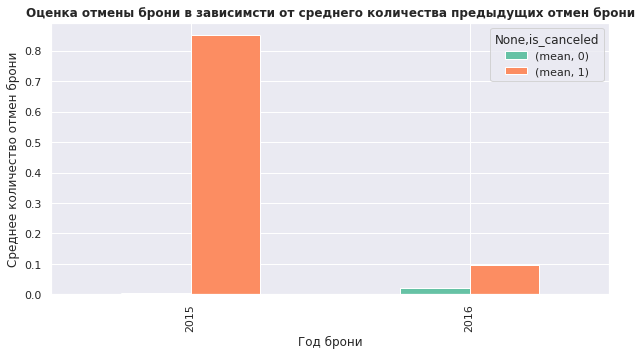

In [50]:
data_train.pivot_table(index='arrival_date_year', columns='is_canceled', values='previous_cancellations', 
                       aggfunc=['mean']).plot(kind='bar', grid=True, figsize=(10,5));
plt.title(f'Оценка отмены брони в зависимсти от среднего количества предыдущих отмен брони', fontweight='bold');
plt.xlabel('Год брони');
plt.ylabel('Среднее количество отмен брони');

В 2015 и 2016 годах клиенты с более высоким средним количеством предыдущих отмен бронирований чаще отменяли свои заказы.

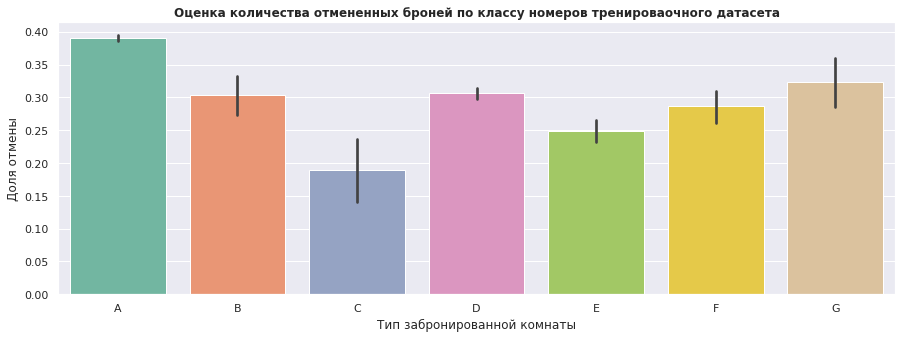

In [51]:
sns.barplot(data=data_train, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G']);
plt.title(f'Оценка количества отмененных броней по классу номеров тренироваочного датасета', fontweight='bold');
plt.xlabel('Тип забронированной комнаты');
plt.ylabel('Доля отмены');

Чаще всего отменяли бронь с номерами классов A и G

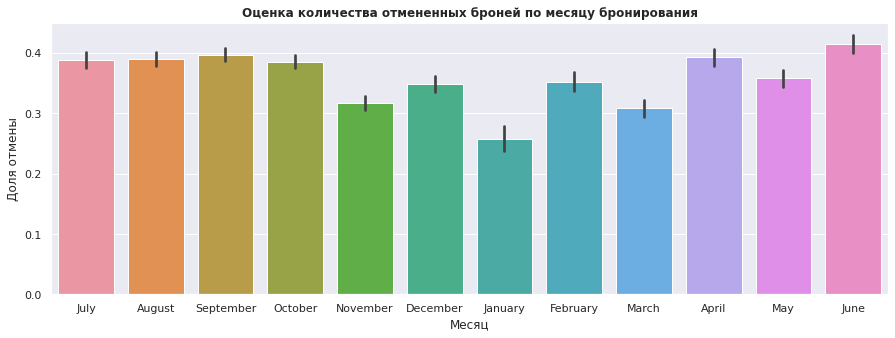

In [52]:
sns.barplot(data=data_train, x='arrival_date_month', y='is_canceled');
plt.title(f'Оценка количества отмененных броней по месяцу бронирования', fontweight='bold');
plt.xlabel('Месяц');
plt.ylabel('Доля отмены');

Чаще всего бронь отменяли летом и в начале осени. Однако можно заметить, что меньше всего отказов от брони в январе.

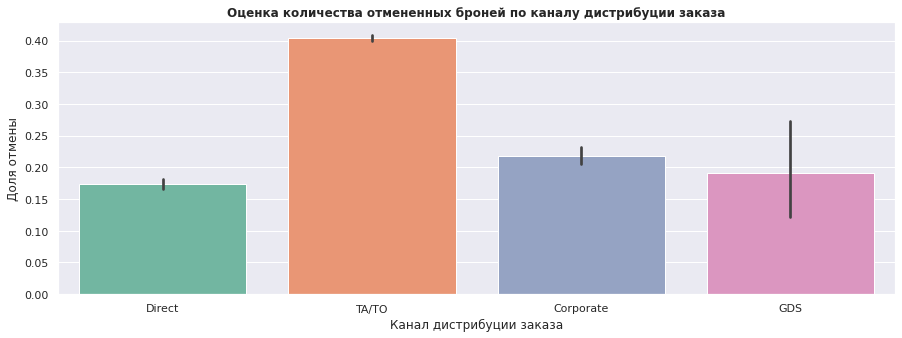

In [53]:
sns.barplot(data=data_train, x='distribution_channel', y='is_canceled');
plt.title(f'Оценка количества отмененных броней по каналу дистрибуции заказа', fontweight='bold');
plt.xlabel('Канал дистрибуции заказа');
plt.ylabel('Доля отмены');

Чаще всего бронь отменяли клиенты с классом `TA/TO`

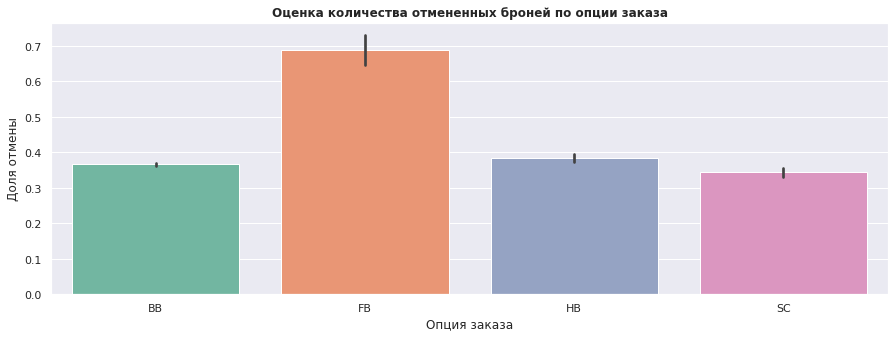

In [54]:
sns.barplot(data=data_train, x='meal', y='is_canceled');
plt.title(f'Оценка количества отмененных броней по опции заказа', fontweight='bold');
plt.xlabel('Опция заказа');
plt.ylabel('Доля отмены');

Чаще всего бронь отменяли клиенты с опцией заказа `FB`

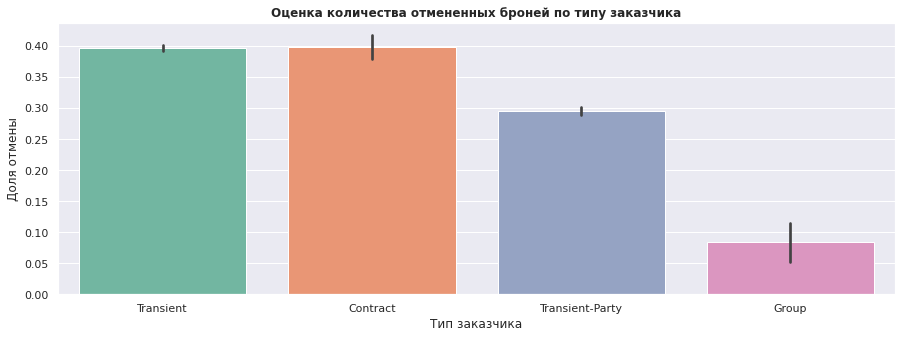

In [55]:
sns.barplot(data=data_train, x='customer_type', y='is_canceled');
plt.title(f'Оценка количества отмененных броней по типу заказчика', fontweight='bold');
plt.xlabel('Тип заказчика');
plt.ylabel('Доля отмены');

Чаще всего бронь отменяли клиенты `Transient` и `Contract`

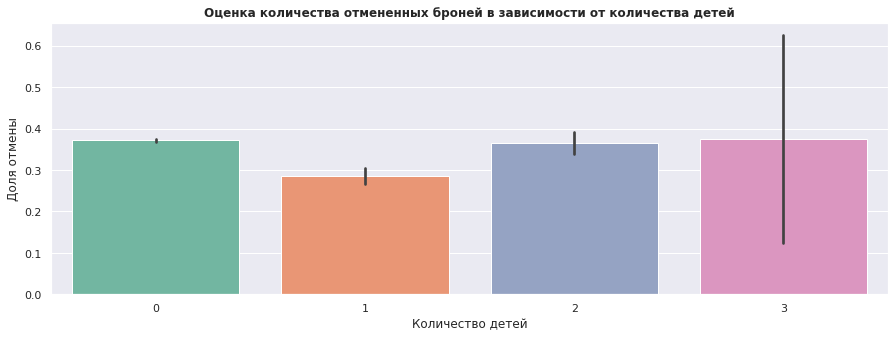

In [56]:
sns.barplot(data=data_train, x='children', y='is_canceled');
plt.title(f'Оценка количества отмененных броней в зависимости от количества детей', fontweight='bold');
plt.xlabel('Количество детей');
plt.ylabel('Доля отмены');

Количество детей практически никак не влияет на отмену брони

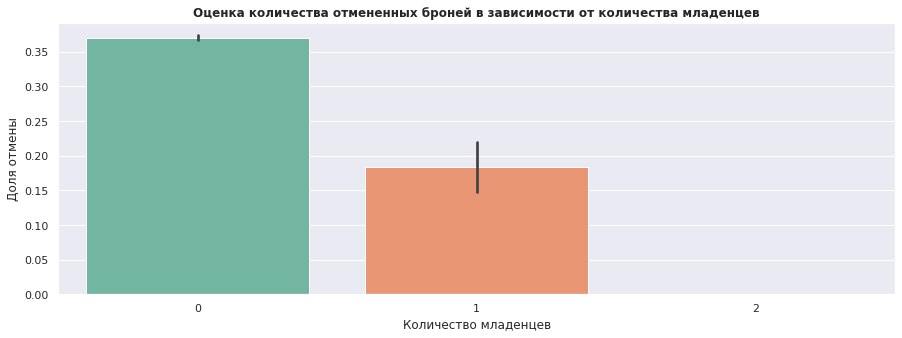

In [57]:
sns.barplot(data=data_train, x='babies', y='is_canceled');
plt.title(f'Оценка количества отмененных броней в зависимости от количества младенцев', fontweight='bold');
plt.xlabel('Количество младенцев');
plt.ylabel('Доля отмены');

Чем меньше у клиентов младенцев, тем больше вероятность отмены.

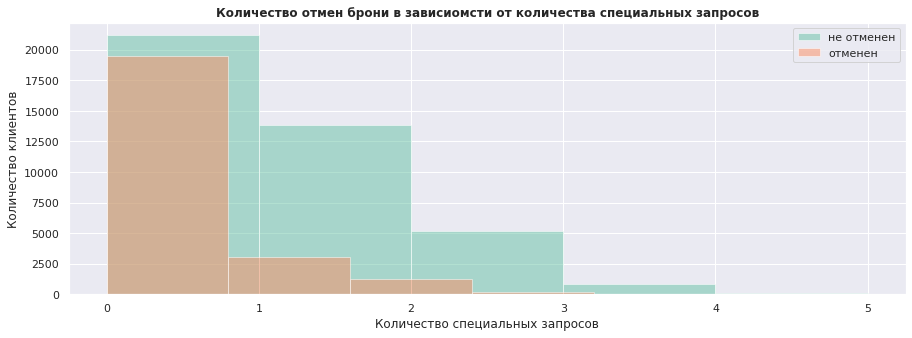

In [58]:
data_train.groupby('is_canceled')['total_of_special_requests'].hist(bins=5, alpha=0.5);
plt.title(f'Количество отмен брони в зависиомсти от количества специальных запросов', fontweight='bold');
plt.xlabel('Количество специальных запросов');
plt.ylabel('Количество клиентов');
plt.legend((['не отменен', 'отменен']));

Можно заметить, что, чем больше специальных запросов, тем меньще отмены броней.

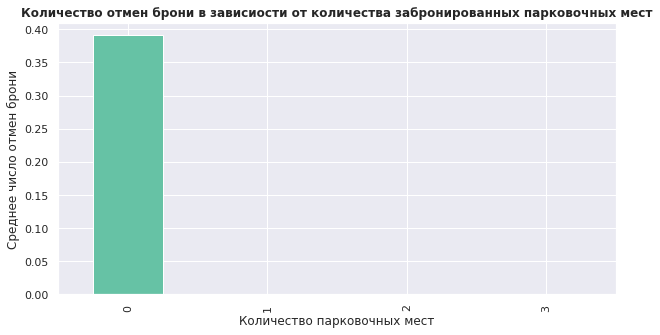

In [59]:
data_train.groupby('required_car_parking_spaces')['is_canceled'].mean().plot(kind='bar', figsize=(10,5));
plt.title('Количество отмен брони в зависиости от количества забронированных парковочных мест', fontweight='bold');
plt.xlabel('Количество парковочных мест');
plt.ylabel('Среднее число отмен брони');

Чем больше парковочных мест забронировано, тем меньше вероятность отмены брони.

Можно преобразовать данный признак в бинарный, так как после анализа понятно, что нам важно именно налчие запроса на паркову.

In [60]:
def car_parking(data):
    if data['required_car_parking_spaces'] == 0:
        return 0
    else:
        return 1

In [61]:
data_train['required_car_parking_spaces'] = data_train.apply(car_parking, axis=1)
data_test['required_car_parking_spaces'] = data_test.apply(car_parking, axis=1)

In [62]:
data_train['required_car_parking_spaces'].unique()

array([0, 1])

Кроме того, также можно поступить и с количеством специальных запросов.

In [63]:
def special_request(data):
    if data['total_of_special_requests'] == 0:
        return 0
    else:
        return 1

In [64]:
data_train['total_of_special_requests'] = data_train.apply(special_request, axis=1)
data_test['total_of_special_requests'] = data_test.apply(special_request, axis=1)

Кроме того, также можно поступить и с количеством младенцев.

In [65]:
def children(data):
    if data['babies'] == 0:
        return 0
    else:
        return 1

In [66]:
data_train['babies'] = data_train.apply(children, axis=1)
data_test['babies'] = data_test.apply(children, axis=1)

In [67]:
data_train['babies'].unique()

array([0, 1])

In [68]:
data_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,0,0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,0,0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,0,0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,0,0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,2,0,0,...,0,0,0,A,0,0,Transient,0,1,3


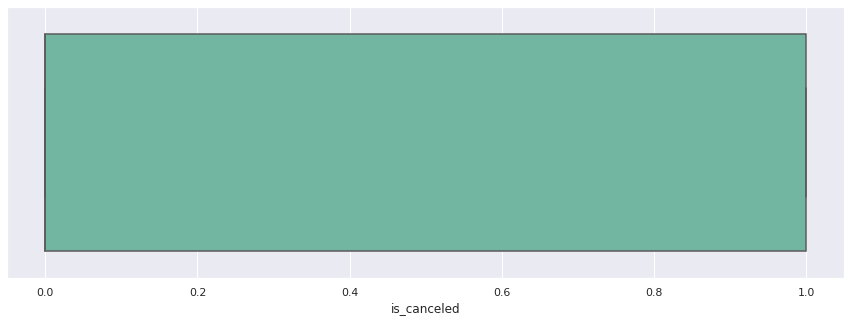

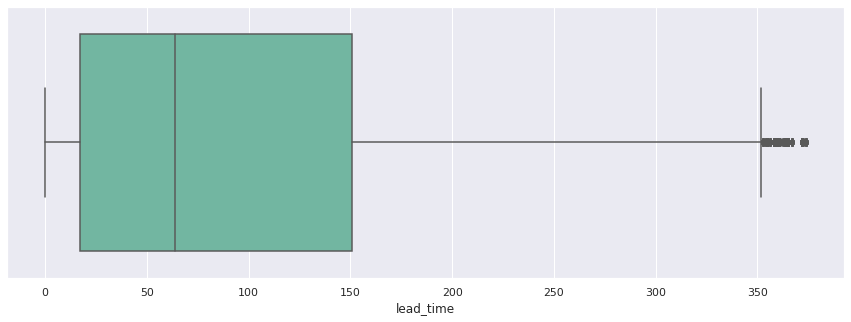

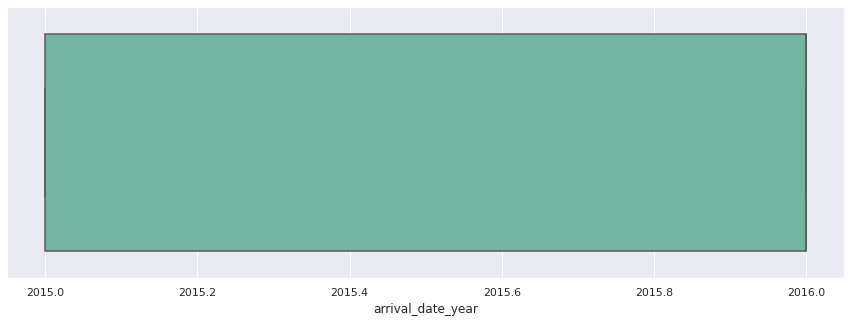

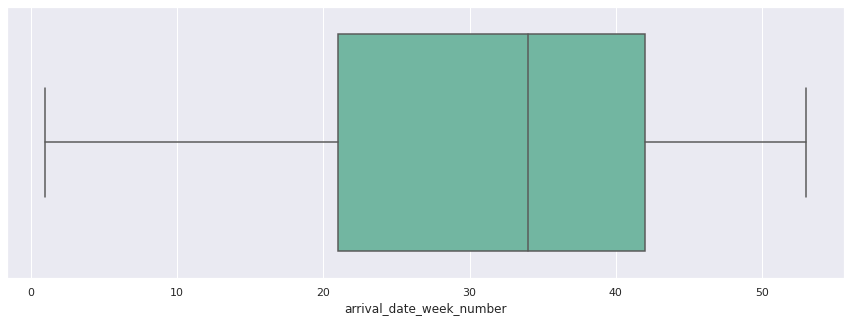

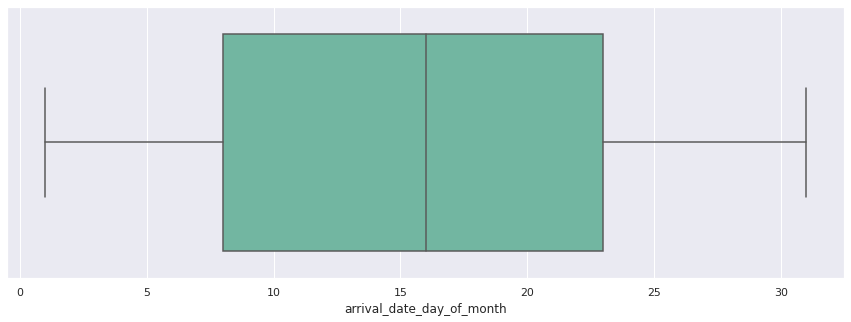

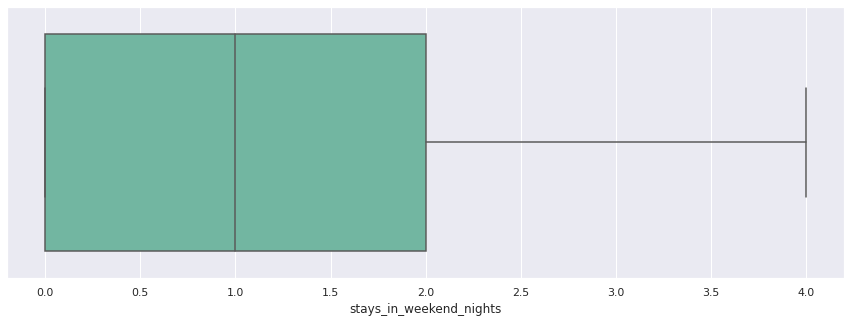

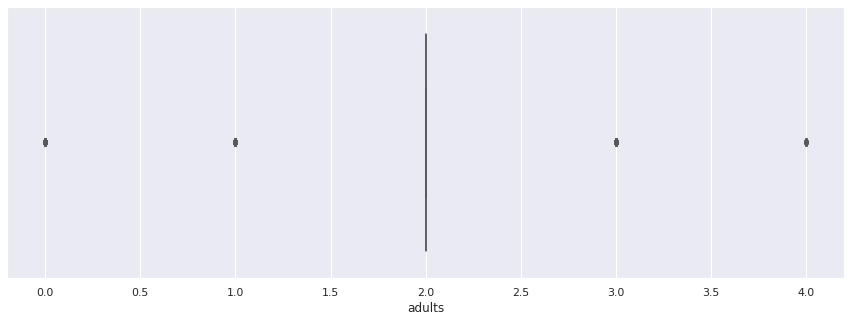

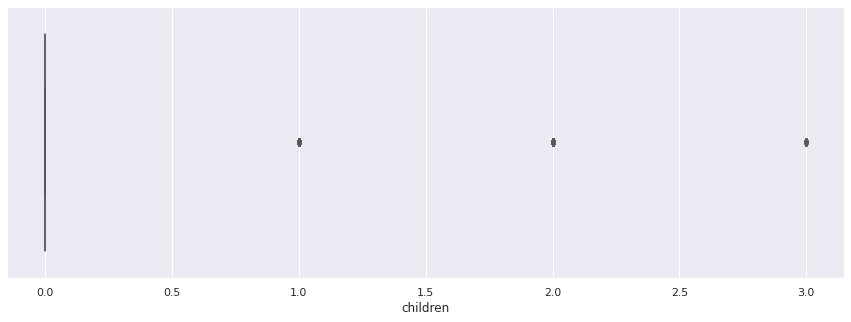

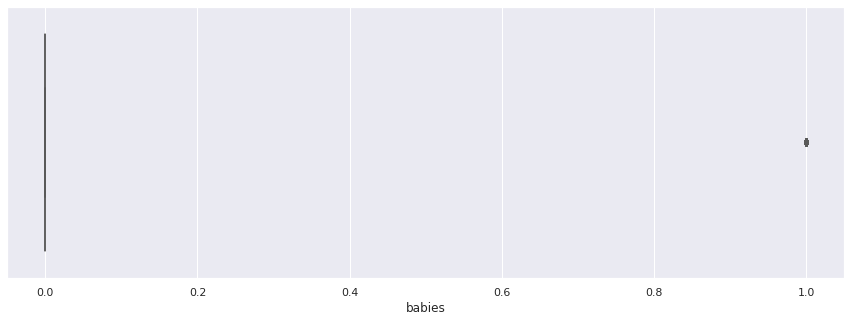

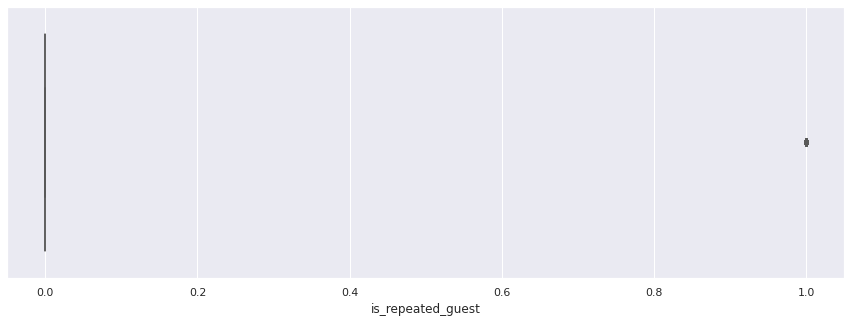

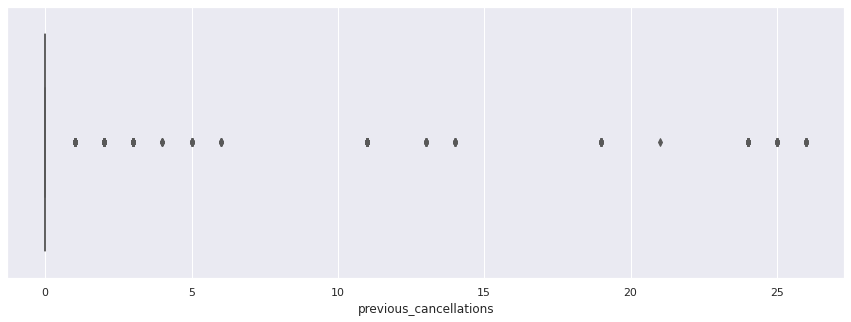

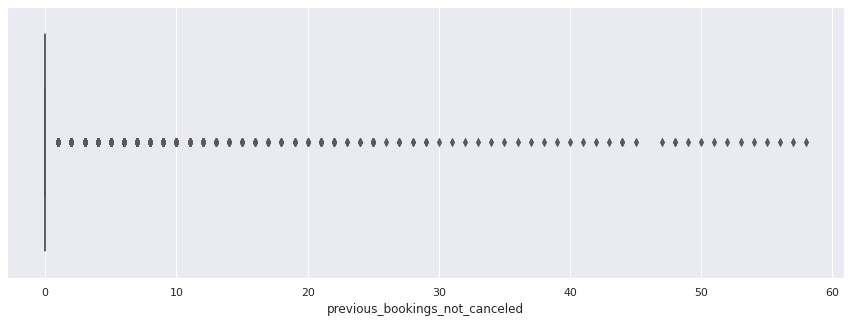

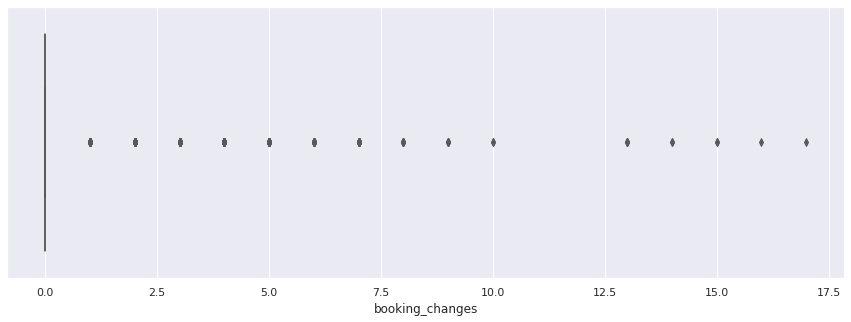

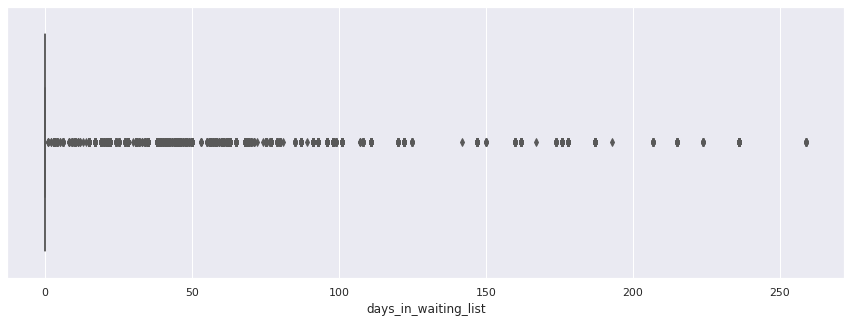

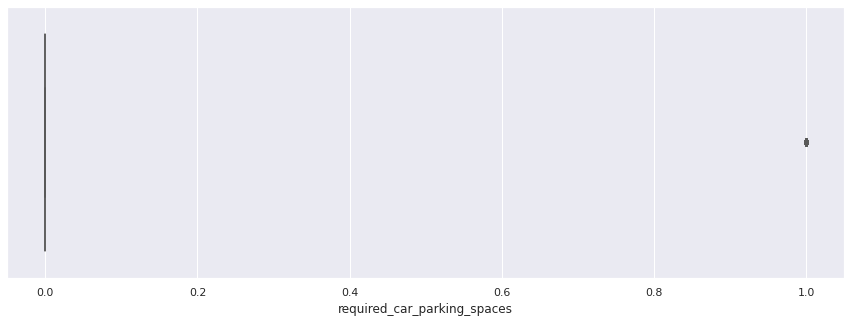

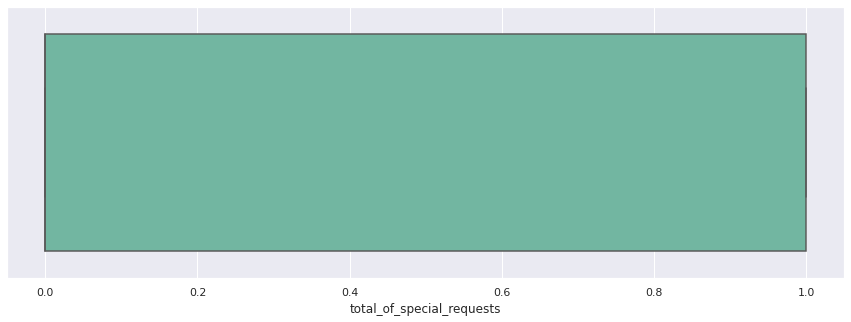

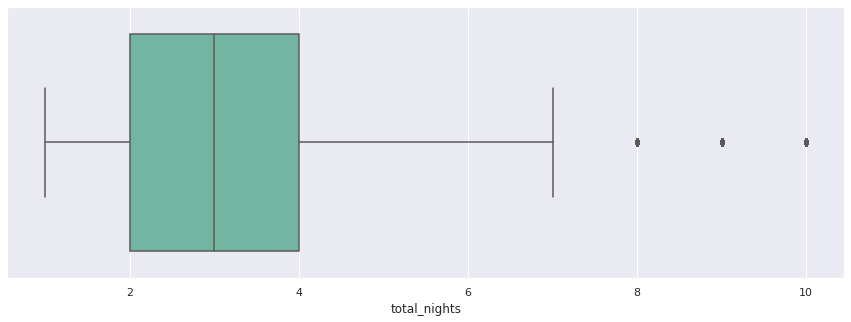

In [69]:
for column in data_train.loc[:, (data_train.dtypes != 'object')].columns:
    sns.boxplot(data_train[column])
    plt.show()

***Выводы:***
1. Больше всего в тренировочных данных заметна положительная корреляция среди столбца load_time
2. Больше всего в тренировочных и тестовыъ данных заметна отрицательная корреляция среди столбца total_of_special_requests
3. Наблюдается дисбаланс целевого признака, доля отмены бронирования колеблется в районе 37-39% в обоих наборах данных.
4. Количество бронирований стабильно высокое в середине года, однако наблюдаются также сезонные повышения, в частности под Новый Год.
5. Каждый год чаще всего отменяли бронь люди, у которых было больше дней между датой заезда и дайтой брони
6. Клиенты с более высоким средним количеством предыдущих отмен бронирований чаще отменяли свои заказы.
7. Чаще всего отменяли бронь с номерами классов A и G.
8. Чаще всего бронь отменяли летом и в начале осени.
9. Чаще всего бронь отменяли клиенты с классом TA/TO
10. Чаще всего бронь отменяли клиенты с опцией заказа FB
11. Чаще всего бронь отменяли клиенты Transient и Contract
12. Количество детей практически никак не влияет на отмену брони
13. Можно заметить, что, чем больше специальных запросов, тем меньще отмены броней.
14. Чем больше парковочных мест забронировано, тем меньше вероятность отмены брони.

## Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

***Оценим прибыль отеля без внедрения депозитов.***

Соберем нужные данные в один датасет

In [70]:
data_profit = data_test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
data_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,1,January,A,1
1,1,January,A,4
2,1,January,A,4
3,1,January,A,4
4,1,January,A,7


Составим таблицу с ценами по категориям

In [71]:
categories = pd.DataFrame({'reserved_room_type' : ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                           'for_night' : [1000, 800, 600, 550, 500, 450, 350],
                           'single_service' : [400, 350, 350, 150, 150, 150, 150]
    
})
categories

,reserved_room_type,for_night,single_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Составим таблицу с коэфициентами по месяцам

In [72]:
months_coef = pd.DataFrame({'arrival_date_month' : ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                       'August', 'September', 'October', 'November', 'December'],
                            'coef' : [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0],
                            'month_number' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
})
months_coef

,arrival_date_month,coef,month_number
0,January,1.0,1
1,February,1.0,2
2,March,1.2,3
3,April,1.2,4
4,May,1.2,5
5,June,1.4,6
6,July,1.4,7
7,August,1.4,8
8,September,1.2,9
9,October,1.2,10


Составим общую таблицу со всеми необходимыми данными

In [73]:
data_profit = data_profit.merge(categories, how='left', on='reserved_room_type')
data_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,for_night,single_service
0,1,January,A,1,1000,400
1,1,January,A,4,1000,400
2,1,January,A,4,1000,400
3,1,January,A,4,1000,400
4,1,January,A,7,1000,400


In [74]:
data_profit = data_profit.merge(months_coef, how='left', on='arrival_date_month')
data_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,for_night,single_service,coef,month_number
0,1,January,A,1,1000,400,1.0,1
1,1,January,A,4,1000,400,1.0,1
2,1,January,A,4,1000,400,1.0,1
3,1,January,A,4,1000,400,1.0,1
4,1,January,A,7,1000,400,1.0,1


In [75]:
# функция расчета прибыли до введения депозита
def profit(data):
    if data['is_canceled'] == 1:
        income = 0
        expans = data['single_service'] + data['for_night'] * data['coef']
    else:
        income = data['total_nights'] * data['for_night'] * data['coef']
        expans = data['total_nights']//2 * data['single_service'] + data['single_service']
    
    return income - expans

In [76]:
# расчет прибыли
data_profit['total_profit'] = data_profit.apply(profit, axis=1)
data_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,for_night,single_service,coef,month_number,total_profit
0,1,January,A,1,1000,400,1.0,1,-1400.0
1,1,January,A,4,1000,400,1.0,1,-1400.0
2,1,January,A,4,1000,400,1.0,1,-1400.0
3,1,January,A,4,1000,400,1.0,1,-1400.0
4,1,January,A,7,1000,400,1.0,1,-1400.0


In [77]:
print(f'Общая прибыль с января по август 2017 года состоавляет: {data_profit["total_profit"].sum()/1000} тыс. рублей')

Общая прибыль с января по август 2017 года состоавляет: 32582.92 тыс. рублей


***Вывод:*** общая прибыль с января по август 2017 года состоавляет: 32582.92 тыс. рублей. без внедрения депозита. Теперь приступим к разработке модели ML.

## Разработка модели ML

Прверим еще раз на наличие дубликатов в данных.

In [78]:
data_train.duplicated().sum()

21520

In [79]:
print(f'Процент дубликатов {data_train.duplicated().sum()/len(data_train["is_canceled"]) * 100}')

Процент дубликатов 32.99247244239349


In [80]:
data_train = data_train.drop_duplicates()

In [81]:
data_train.duplicated().sum()

0

Отделяем целевой признак

In [82]:
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']

features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

Обрабатываем качественные данные с помощью Binary Encoder

In [83]:
binary = ce.BinaryEncoder()

columns = features_train.select_dtypes(include=['object']).columns

binary.fit(features_train)
features_train = binary.transform(features_train)

In [84]:
features_test = binary.transform(features_test)

In [85]:
features_train.head()

,lead_time,arrival_date_year,arrival_date_month_0,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,...,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests,total_nights
0,7.0,2015,0,0,0,1,27,1,0,1,...,0,1,0,0,0,0,1,0,0,1
1,14.0,2015,0,0,0,1,27,1,0,2,...,0,1,0,0,0,0,1,0,1,2
2,0.0,2015,0,0,0,1,27,1,0,2,...,1,0,0,0,0,0,1,0,0,2
3,9.0,2015,0,0,0,1,27,1,0,2,...,1,0,0,0,0,0,1,0,1,2
4,85.0,2015,0,0,0,1,27,1,0,2,...,0,1,0,0,0,0,1,0,1,3


In [86]:
features_test.head()

,lead_time,arrival_date_year,arrival_date_month_0,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,...,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests,total_nights
0,74.0,2017,0,1,1,1,1,1,1,2,...,0,1,0,0,0,0,1,0,0,1
1,62.0,2017,0,1,1,1,1,1,2,2,...,0,1,0,0,0,0,1,0,1,4
2,62.0,2017,0,1,1,1,1,1,2,2,...,0,1,0,0,0,0,1,0,1,4
3,71.0,2017,0,1,1,1,1,1,2,1,...,0,1,0,0,0,0,1,0,1,4
4,172.0,2017,0,1,1,1,1,1,2,2,...,0,1,0,0,0,0,1,0,0,7


In [87]:
print('Кол-во строк и столбцов после BE в обучающей выборке:', features_train.shape)
print('Кол-во строк и столбцов после BE в тестовой выборке:', features_test.shape)

Кол-во строк и столбцов после BE в обучающей выборке: (43707, 40)
Кол-во строк и столбцов после BE в тестовой выборке: (32412, 40)


In [88]:
# масштабируем данные
numeric = [*features_train.select_dtypes(exclude=['object']).columns]

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [89]:
features_train.head()

,lead_time,arrival_date_year,arrival_date_month_0,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,...,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.822330,-1.859469,-0.709839,-0.836541,-0.996232,1.037089,-0.294311,-1.683878,-1.032735,-1.693987,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,-0.974048,-1.175522
1,-0.727661,-1.859469,-0.709839,-0.836541,-0.996232,1.037089,-0.294311,-1.683878,-1.032735,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,-0.642958
2,-0.916998,-1.859469,-0.709839,-0.836541,-0.996232,1.037089,-0.294311,-1.683878,-1.032735,0.285086,...,1.773250,-3.309814,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,-0.974048,-0.642958
3,-0.795282,-1.859469,-0.709839,-0.836541,-0.996232,1.037089,-0.294311,-1.683878,-1.032735,0.285086,...,1.773250,-3.309814,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,-0.642958
4,0.232546,-1.859469,-0.709839,-0.836541,-0.996232,1.037089,-0.294311,-1.683878,-1.032735,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,-0.110395


In [90]:
features_test.head()

,lead_time,arrival_date_year,arrival_date_month_0,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,...,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests,total_nights
0,0.083781,2.935045,-0.709839,1.195398,1.003782,1.037089,-2.165619,-1.683878,0.119855,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,-0.974048,-1.175522
1,-0.078507,2.935045,-0.709839,1.195398,1.003782,1.037089,-2.165619,-1.683878,1.272446,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,0.422169
2,-0.078507,2.935045,-0.709839,1.195398,1.003782,1.037089,-2.165619,-1.683878,1.272446,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,0.422169
3,0.043209,2.935045,-0.709839,1.195398,1.003782,1.037089,-2.165619,-1.683878,1.272446,-1.693987,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,1.026644,0.422169
4,1.409137,2.935045,-0.709839,1.195398,1.003782,1.037089,-2.165619,-1.683878,1.272446,0.285086,...,-0.563936,0.302132,-0.367013,-0.082743,-0.077058,-0.479516,0.226117,-0.299327,-0.974048,2.019859


***1.1 Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.***

Выбранная метрика качества - полнота (recall), так как нам важно сократитить долю ложноотрицателньных ответов, ибо такие отказники, которых модель ложно определит, и принесут отелю убытки, а также presicion, так как такие клиенты, у которых мы возьмем депозит зря, могут обидеться.

**Logistic Regression**

Обучение модели логистической регрессии 

In [91]:
lr_model = LogisticRegression(random_state=25, n_jobs=-1, class_weight='balanced')

lr_params = {
    'penalty' : ['l1', 'l2', 'elasticnet', None],
    'C' : range(1, 100, 5),
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# подбор параметров
gs_lr = RandomizedSearchCV(
    lr_model, 
    param_distributions=lr_params, 
    scoring='recall', 
    n_jobs=-1,
    random_state=25
)

gs_lr.fit(features_train, target_train)

gs_lr_best_params = gs_lr.best_params_
print(f'best_params: {gs_lr_best_params}')

best_params: {'solver': 'saga', 'penalty': 'l2', 'C': 41}


In [92]:
print(f'Кросс-валидация Recall: {gs_lr.best_score_}')

Кросс-валидация Recall: 0.6013118654873673


In [93]:
results = pd.DataFrame(gs_lr.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006809,0.003063,0.000000,0.000000,liblinear,elasticnet,6,"{'solver': 'liblinear', 'penalty': 'elasticnet...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,2.920975,0.112017,0.006924,0.000204,saga,l2,41,"{'solver': 'saga', 'penalty': 'l2', 'C': 41}",0.655870,0.418615,0.574899,0.564103,0.793072,0.601312,0.122645,1
2,0.039312,0.040705,0.000000,0.000000,newton-cholesky,l2,96,"{'solver': 'newton-cholesky', 'penalty': 'l2',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,4.385495,1.971540,0.096547,0.018470,lbfgs,l2,31,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 31}",0.653171,0.415917,0.574899,0.563653,0.796671,0.600862,0.124371,3
4,0.019445,0.025288,0.000000,0.000000,newton-cg,elasticnet,61,"{'solver': 'newton-cg', 'penalty': 'elasticnet...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
5,0.006618,0.000209,0.000000,0.000000,liblinear,None,31,"{'solver': 'liblinear', 'penalty': None, 'C': 31}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,0.007104,0.001006,0.000000,0.000000,lbfgs,l1,21,"{'solver': 'lbfgs', 'penalty': 'l1', 'C': 21}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,3.555896,0.103424,0.062312,0.037110,saga,l1,76,"{'solver': 'saga', 'penalty': 'l1', 'C': 76}",0.655870,0.418615,0.574899,0.564103,0.793072,0.601312,0.122645,1
8,0.019407,0.026757,0.000000,0.000000,lbfgs,l1,71,"{'solver': 'lbfgs', 'penalty': 'l1', 'C': 71}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,0.005467,0.000494,0.000000,0.000000,newton-cholesky,l2,6,"{'solver': 'newton-cholesky', 'penalty': 'l2',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [94]:
print(f'Recall: {recall_score(target_train, gs_lr.predict(features_train))}')

Recall: 0.7311982727599856


**Random Forest Classifier**

Обучение модели случайного леса

In [95]:
model_rf = RandomForestClassifier(random_state=25, class_weight='balanced')

param_grid_rf = {
    'n_estimators': range(10, 101, 10),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 10),
    'max_depth' : range(2, 30)
}

# подбор параметров
rs_rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=param_grid_rf, 
    scoring='recall', 
    n_jobs=-1,
    random_state=25
)

rs_rf.fit(features_train, target_train)

rs_rf_best_params = rs_rf.best_params_
print(f'best_params: {rs_rf_best_params}')

best_params: {'n_estimators': 60, 'min_samples_split': 3, 'max_depth': 5, 'criterion': 'gini'}


In [96]:
print(f'Кросс-валидация Recall: {rs_rf.best_score_}')

Кросс-валидация Recall: 0.5825979297533632


In [97]:
results = pd.DataFrame(rs_rf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.208685,0.034657,0.072807,0.006203,90,9,5,gini,"{'n_estimators': 90, 'min_samples_split': 9, '...",0.757535,0.415018,0.481781,0.380567,0.735942,0.554169,0.160711,2
1,0.712982,0.025608,0.044967,0.001427,20,5,29,gini,"{'n_estimators': 20, 'min_samples_split': 5, '...",0.392713,0.259892,0.118309,0.125056,0.545659,0.288326,0.163394,9
2,1.063419,0.039513,0.061550,0.002954,50,7,10,entropy,"{'n_estimators': 50, 'min_samples_split': 7, '...",0.627980,0.421763,0.331084,0.282051,0.767431,0.486062,0.183893,3
3,0.799155,0.022878,0.050847,0.003347,60,3,5,gini,"{'n_estimators': 60, 'min_samples_split': 3, '...",0.764283,0.424011,0.546559,0.410256,0.767881,0.582598,0.157156,1
4,1.763214,0.118686,0.097827,0.002891,60,7,16,gini,"{'n_estimators': 60, 'min_samples_split': 7, '...",0.529915,0.366007,0.210976,0.201080,0.722897,0.406175,0.198698,5
5,0.363107,0.031090,0.026222,0.001547,10,7,26,gini,"{'n_estimators': 10, 'min_samples_split': 7, '...",0.448493,0.280126,0.156545,0.131804,0.512821,0.305958,0.152597,8
6,0.295003,0.009479,0.023540,0.001585,10,6,16,gini,"{'n_estimators': 10, 'min_samples_split': 6, '...",0.546559,0.395683,0.220873,0.200180,0.623482,0.397355,0.169365,6
7,1.895726,0.074293,0.111674,0.009409,50,2,26,gini,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.350427,0.236061,0.076923,0.096716,0.466937,0.245413,0.148787,10
8,0.724420,0.044869,0.045224,0.001523,20,6,25,gini,"{'n_estimators': 20, 'min_samples_split': 6, '...",0.437697,0.282824,0.120558,0.122807,0.578947,0.308567,0.179051,7
9,1.722893,0.064379,0.098786,0.002172,60,6,15,entropy,"{'n_estimators': 60, 'min_samples_split': 6, '...",0.568601,0.376799,0.230319,0.221772,0.753936,0.430285,0.205039,4


**Decision Tree Classifier**

Обучение модели дерева решений

In [98]:
model_dt = DecisionTreeClassifier(random_state=25, class_weight='balanced')

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(5, 100, 5),
    'min_samples_split' : range(1, 20)
}

# подбор параметров
rs_dt = RandomizedSearchCV(
    model_dt, 
    param_distributions=param_grid_dt, 
    scoring='recall', 
    n_jobs=-1,
    random_state=25,
    n_iter=50
)

rs_dt.fit(features_train, target_train)

rs_dt_best_params = rs_dt.best_params_
print(f'best_params: {rs_dt_best_params}')

best_params: {'splitter': 'random', 'min_samples_split': 8, 'max_depth': 5, 'criterion': 'gini'}


In [99]:
print(f'Кросс-валидация Recall: {rs_dt.best_score_}')

Кросс-валидация Recall: 0.6952206655728048


In [100]:
results = pd.DataFrame(rs_dt.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_split,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.169951,0.019586,0.008078,0.000725,random,3,25,gini,"{'splitter': 'random', 'min_samples_split': 3,...",0.458390,0.308004,0.210076,0.221323,0.542960,0.348150,0.131807,39
1,0.193498,0.061050,0.009537,0.001664,random,8,95,entropy,"{'splitter': 'random', 'min_samples_split': 8,...",0.486280,0.360612,0.260459,0.286550,0.640126,0.406805,0.140547,21
2,0.230188,0.014324,0.007837,0.000648,best,9,50,gini,"{'splitter': 'best', 'min_samples_split': 9, '...",0.446244,0.330935,0.192083,0.247863,0.529915,0.349408,0.124389,36
3,0.358321,0.147108,0.019200,0.021330,best,14,45,gini,"{'splitter': 'best', 'min_samples_split': 14, ...",0.466037,0.351619,0.207377,0.285650,0.560954,0.374327,0.126089,33
4,0.151564,0.004889,0.008751,0.001295,random,10,25,entropy,"{'splitter': 'random', 'min_samples_split': 10...",0.514170,0.369155,0.285650,0.255061,0.604139,0.405635,0.133853,23
5,0.148897,0.004257,0.007572,0.000035,random,8,95,gini,"{'splitter': 'random', 'min_samples_split': 8,...",0.471885,0.345324,0.255061,0.317589,0.615385,0.401049,0.128328,24
6,0.017277,0.000514,0.000000,0.000000,random,1,80,entropy,"{'splitter': 'random', 'min_samples_split': 1,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
7,0.152051,0.008743,0.007736,0.000509,random,18,90,entropy,"{'splitter': 'random', 'min_samples_split': 18...",0.558704,0.346223,0.304993,0.376518,0.576698,0.432627,0.112744,14
8,0.215444,0.015089,0.007530,0.000493,best,15,50,gini,"{'splitter': 'best', 'min_samples_split': 15, ...",0.465587,0.353417,0.207377,0.282951,0.578048,0.377476,0.131484,32
9,0.137390,0.004543,0.007408,0.000177,random,18,80,entropy,"{'splitter': 'random', 'min_samples_split': 18...",0.558704,0.346223,0.304993,0.376518,0.576698,0.432627,0.112744,14


**Выбор лучшей модели**

Выбрана модель - Decision Tree, так как она показала лучший показатель на кросс-валидации.

In [101]:
dt_probabilities_one_train = rs_dt.predict_proba(features_train)[:, 1]
auc_roc_dt_train = roc_auc_score(target_train, dt_probabilities_one_train)

dt_probabilities_one_test = rs_dt.predict_proba(features_test)[:, 1]
auc_roc_dt_test = roc_auc_score(target_test, dt_probabilities_one_test)

Cоставим таблицу с показателями модели DT на тестовых данных

In [102]:
table_DT = pd.DataFrame(index=['train', 'test'],
                        columns = ['precision', 'recall', 'F1-score', 'ROC-AUC score'])
table_DT['precision'] = precision_score(target_train, rs_dt.predict(features_train)), \
precision_score(target_test, rs_dt.predict(features_test)),\

table_DT['recall'] = recall_score(target_train, rs_dt.predict(features_train)), \
recall_score(target_test, rs_dt.predict(features_test)),\

table_DT['F1-score'] = f1_score(target_train, rs_dt.predict(features_train)), \
f1_score(target_test, rs_dt.predict(features_test)),\

table_DT['ROC-AUC score'] = auc_roc_dt_train, auc_roc_dt_test

table_DT

,precision,recall,F1-score,ROC-AUC score
train,0.378668,0.813782,0.516840,0.748158
test,0.538115,0.767532,0.632668,0.750931


**Оценим прибыль, которую принесёт эта модель за год.**

In [103]:
# таблица предсказаний модели DT
predictions = {
               'DT_pred': rs_dt.predict(features_test)
              }

predictions = pd.DataFrame(predictions)
predictions

,DT_pred
0,1
1,0
2,0
3,1
4,1
...,...
32407,1
32408,0
32409,1
32410,0


Составляем общую таблицу для вычисления прибыли после внедрения модели

In [104]:
data_profit_predictions = data_profit.merge(predictions, how='left', left_index=True, right_index=True)

In [105]:
data_profit_predictions

,is_canceled,arrival_date_month,reserved_room_type,total_nights,for_night,single_service,coef,month_number,total_profit,DT_pred
0,1,January,A,1,1000,400,1.0,1,-1400.0,1
1,1,January,A,4,1000,400,1.0,1,-1400.0,0
2,1,January,A,4,1000,400,1.0,1,-1400.0,0
3,1,January,A,4,1000,400,1.0,1,-1400.0,1
4,1,January,A,7,1000,400,1.0,1,-1400.0,1
...,...,...,...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.4,8,6800.0,1
32408,0,August,A,7,1000,400,1.4,8,8200.0,0
32409,0,August,A,7,1000,400,1.4,8,8200.0,1
32410,0,August,D,7,550,150,1.4,8,4790.0,0


In [106]:
# функция расчета прибыли после внедрения депозита
def predict_profit(data):
    if data['is_canceled'] == 0:
        income = data['total_nights'] * data['for_night'] * data['coef']
        expans = data['total_nights']//2 * data['single_service'] + data['single_service']
    elif (data['is_canceled'] == 1) & (data['DT_pred'] == 1):
        income = 0.8 * (data['for_night'] * data['coef'] + data['single_service'])
        expans = data['single_service'] + data['for_night'] * data['coef']
    elif (data['is_canceled'] == 1) & (data['DT_pred'] == 0):
        income = 0
        expans = data['single_service'] + data['for_night'] * data['coef'] 
    return income - expans

In [107]:
# расчет прибыли
data_profit_predictions['profit_DT'] = data_profit_predictions.apply(predict_profit, axis=1)

In [108]:
data_profit_predictions.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,for_night,single_service,coef,month_number,total_profit,DT_pred,profit_DT
0,1,January,A,1,1000,400,1.0,1,-1400.0,1,-280.0
1,1,January,A,4,1000,400,1.0,1,-1400.0,0,-1400.0
2,1,January,A,4,1000,400,1.0,1,-1400.0,0,-1400.0
3,1,January,A,4,1000,400,1.0,1,-1400.0,1,-280.0
4,1,January,A,7,1000,400,1.0,1,-1400.0,1,-280.0


In [109]:
print(f'Прибыль отеля после внедрения модели: {data_profit_predictions["profit_DT"].sum()}')

Прибыль отеля после внедрения модели: 43747864.0


In [110]:
print(f'Прибыль отеля от введения модели: \
{data_profit_predictions["profit_DT"].sum() - data_profit_predictions["total_profit"].sum()} руб.')

Прибыль отеля от введения модели: 11164944.0 руб.


In [111]:
print(f'Прибыль отеля от введения модели с учетом затрат на разработку: \
{data_profit_predictions["profit_DT"].sum() - data_profit_predictions["total_profit"].sum() - 400000} руб.')

Прибыль отеля от введения модели с учетом затрат на разработку: 10764944.0 руб.


Проверим гипотезу о повшении прыбыли после внедрения модели с помощью p-value
- Ho - прибыль не увеличилась
- H1 - прибыль увеличилась

In [112]:
results = st.ttest_ind(data_profit_predictions['total_profit'], data_profit_predictions['profit_DT'])
alpha = .05

#делим на два, так как проводим односторонний тест
print('p-значение:', results.pvalue / 2) 

if (results.pvalue / 2) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-значение: 1.3535853891226536e-85
Отвергаем нулевую гипотезу


In [113]:
print(f'Предполагаемая прибыль от внедрения модели отеля за год: \
{(data_profit_predictions["profit_DT"].sum() - data_profit_predictions["total_profit"].sum() - 400000)/8*12} руб.')

Предполагаемая прибыль от внедрения модели отеля за год: 16147416.0 руб.


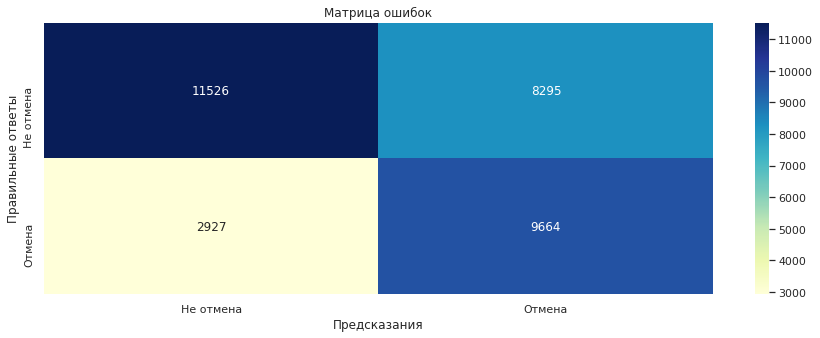

In [114]:
sns.heatmap(confusion_matrix(target_test, rs_dt.predict(features_test)), cmap='YlGnBu', annot=True, fmt='g', 
            xticklabels=['Не отмена', 'Отмена'], yticklabels=['Не отмена', 'Отмена'])
plt.title(f'Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()

Модель DT показывет следующие результаты по ошибкам:
- Ошибка первого рода (неверно отвергнутое): 8295
- Ошибка второго рода (неверно принятое): 2927

То есть вероятность модели ошибочно взять депозит с клиентов больше, чем потерпеть убытки от клиентов, которые отменят бронь и не заплатять депозит.

***Вывод:***
В качестве лучшей модели была выбрана модель Desicion Tree. Кросс-валидация показала результат = 0.6952206655728048. Она выдала следуюшие показатели на тестовых данных:
1. Precision: 0.538115
2. Recall: 0.767532	
3. F1-score: 0.632668	
4. ROC AUC score: 0.750931

Если верить тесту p-value, то прибыль после внедрения модели увеличится. Предполагаемая прибыль за год с учетом затрат на разработку системы - 16 млн. руб.
<br>Это значительно перекрывает затраты на ее разработку (400 тыс.).

Модель DT показывет следующие результаты по ошибкам:
- Ошибка первого рода (неверно отвергнутое): 8295
- Ошибка второго рода (неверно принятое): 2927

То есть вероятность модели ошибочно взять депозит с клиентов больше, чем потерпеть убытки от клиентов, которые отменят бронь и не заплатять депозит.

## Портрет «ненадёжного» клиента

Добавим к тестовому набору данных столбец с предсказаниями, чтобы провести анализ ненадежного клиента

In [115]:
data_test_predictions = data_test.merge(predictions, how='left', left_index=True, right_index=True)

data_test_predictions

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,DT_pred
0,1,74.0,2017,January,1,1,1,2,0,0,...,0,0,A,0,0,Transient,0,0,1,1
1,1,62.0,2017,January,1,1,2,2,0,0,...,0,0,A,0,0,Transient,0,1,4,0
2,1,62.0,2017,January,1,1,2,2,0,0,...,0,0,A,0,0,Transient,0,1,4,0
3,1,71.0,2017,January,1,1,2,1,0,0,...,0,0,A,0,0,Transient,0,1,4,1
4,1,172.0,2017,January,1,1,2,2,0,0,...,0,0,A,0,0,Transient,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164.0,2017,August,35,31,2,2,0,0,...,0,0,A,0,0,Transient,0,0,6,1
32408,0,21.0,2017,August,35,30,2,2,0,0,...,0,0,A,0,0,Transient,0,1,7,0
32409,0,23.0,2017,August,35,30,2,2,0,0,...,0,0,A,0,0,Transient,0,0,7,1
32410,0,34.0,2017,August,35,31,2,2,0,0,...,0,0,D,0,0,Transient,0,1,7,0


Создадим функцию для сравнения категориальных признаков относительно фактическому и предсказанному целевому признаку

In [116]:
def categories_comparison(column):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f'Сравнение зависимости отмены бронирования от категорий {column}', fontweight="bold")
    sns.barplot(data=data_test_predictions, x=column, y='is_canceled', ax=ax[0])
    ax[0].set_title('Фактические отмены')
    ax[0].set_xlabel('Категории')
    ax[0].set_ylabel('Зависимость целевого признака')
    sns.barplot(data=data_test_predictions, x=column, y='DT_pred', ax=ax[1])
    ax[1].set_title('Предсказанные отмены')
    ax[1].set_xlabel('Категории')
    ax[1].set_ylabel('Зависимость целевого признака')
    plt.show()

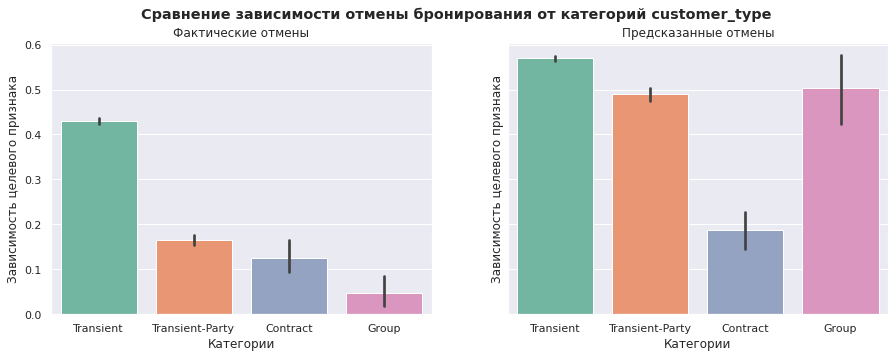

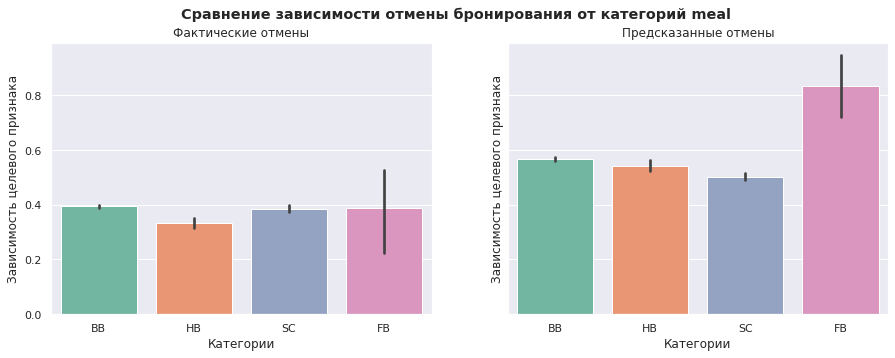

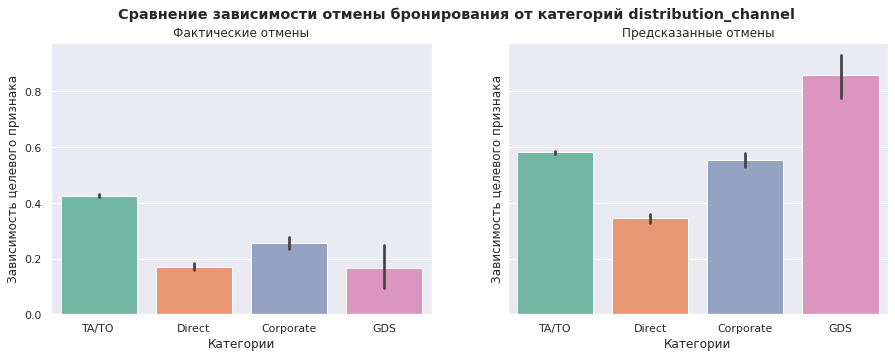

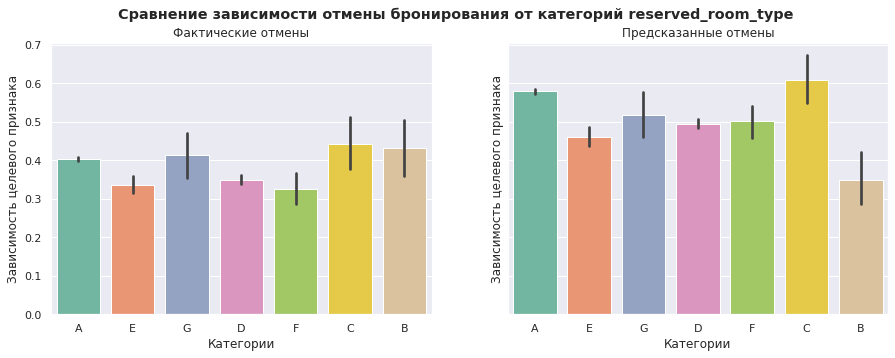

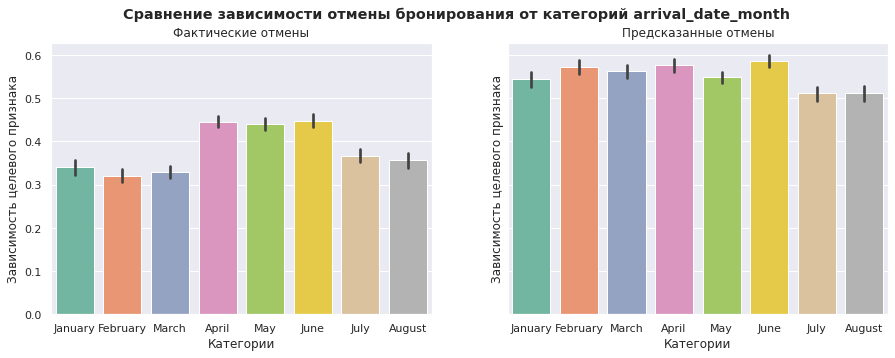

In [117]:
columns = ['customer_type', 'meal', 'distribution_channel', 'reserved_room_type', 'arrival_date_month']
for column in columns:
    categories_comparison(column)

***Из графиков выидно, что:***
1. Фактически и по предсказаниям модели чаще отменяют бронирование люди с категорией `Transient`;
2. В категории `meal` фактически нет особых скачков по показателят, однако модель придала большее значение категории `FB`;
3. Что касается категории `distribution_channel` моедль оказалась солидрарна с фактическими показателями, предсказав, что больше отмен у категории `TA/TO`;
4. В отношении `reserved_room_type` фактически отменяют в основном категории С, B, A, G. Однако модель предсказала, что больше всего отменяют категории G, A, F, C;
5. Как фактически, так и по предсказаниям модели больше всего отказываются от брони в конце весны и начале лета, а именно в  апреле, мае и июне.

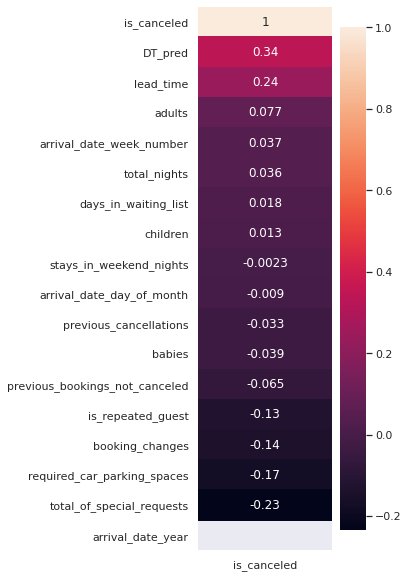

In [118]:
plt.figure(figsize=(3,10))
sns.heatmap(data_test_predictions.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True);

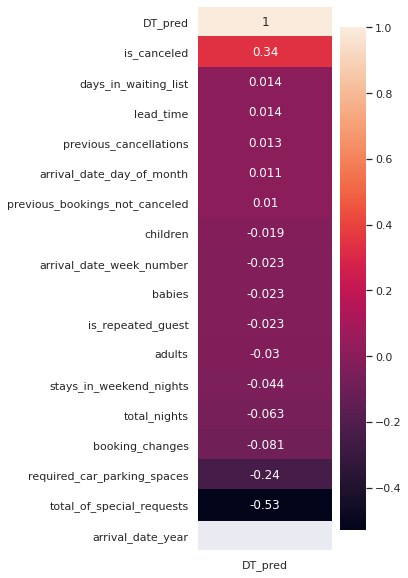

In [119]:
plt.figure(figsize=(3,10))
sns.heatmap(data_test_predictions.corr()[['DT_pred']].sort_values('DT_pred', ascending=False), annot = True);

Корреляция все также показывает сильную зависимости от показателя `load_time`. Возможно, чем больше есть времени на раздумья, тем больше вероятноть отмены брони. Также наличие специальных запросов остается в сильной зависимости. Конечно, чем больше удовлетворяются специальные потребности, тем больше доверия и не хочется отменять бронь.

<AxesSubplot:xlabel='required_car_parking_spaces'>

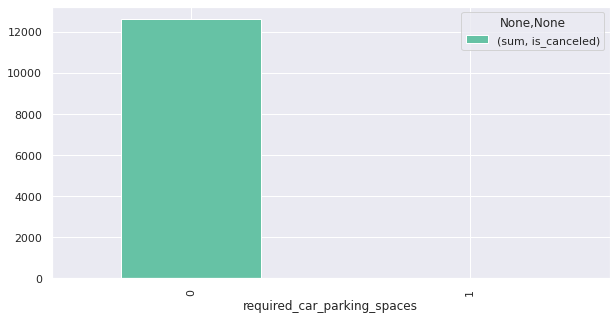

In [120]:
data_test_predictions.pivot_table(index='required_car_parking_spaces', values='is_canceled', aggfunc=['sum'])\
.plot(kind='bar', grid=True, figsize=(10,5))

<AxesSubplot:xlabel='required_car_parking_spaces'>

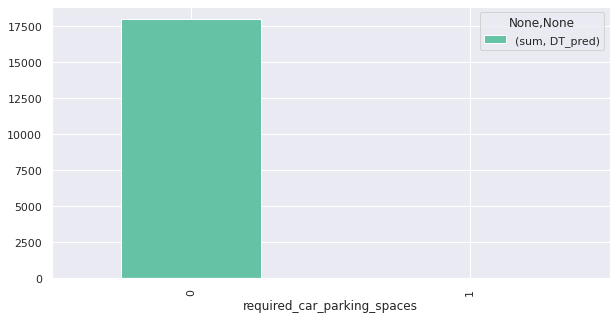

In [121]:
data_test_predictions.pivot_table(index='required_car_parking_spaces', values='DT_pred', aggfunc=['sum'])\
.plot(kind='bar', grid=True, figsize=(10,5))

Как фактически, так и согласно прогнозам модели, те, кому нужно меньше парковочных мест, больше всего отказываются от брони.

***Вывод о "ненадежном клиенте" по итогам исследовательского анализа данных:***
1. Каждый год чаще всего отменяли бронь люди, у которых было больше дней между датой заезда и дайтой брони
2. Клиенты с более высоким средним количеством предыдущих отмен бронирований чаще отменяли свои заказы.
3. Чаще всего отменяли бронь с номерами классов `A` и `G`.
4. Чаще всего бронь отменяли летом и в начале осени.
5. Чаще всего бронь отменяли клиенты с классом `TA/TO`
6. Чаще всего бронь отменяли клиенты с опцией заказа `FB`
7. Чаще всего бронь отменяли клиенты `Transient` и `Contract`
8. Количество детей практически никак не влияет на отмену брони
9. Можно заметить, что, чем больше специальных запросов, тем меньще отмены броней.
10. Чем больше парковочных мест забронировано, тем меньше вероятность отмены брони.

***Отличия по сравнению с предскзааниями модели:***
1. По предсказаниям модели больше всего отказываются от брони в конце весны и начале лета, а именно в  апреле, мае и июне, фактически же чаще всего бронь отменяли летом и в начале осени.

## Общий вывод

***Для начала была проведена предобработка и анализа данных. Были сделаны следующие выводы:***
1. Больше всего в тренировочных данных заметна положительная корреляция среди столбца load_time
2. Больше всего в тренировочных и тестовыъ данных заметна отрицательная корреляция среди столбца total_of_special_requests
3. Наблюдается дисбаланс целевого признака, доля отмены бронирования колеблется в районе 37-39% в обоих наборах данных.
4. Количество бронирований стабильно высокое в середине года, однако наблюдаются также сезонные повышения, в частности под Новый Год.
5. Каждый год чаще всего отменяли бронь люди, у которых было больше дней между датой заезда и дайтой брони
6. Клиенты с более высоким средним количеством предыдущих отмен бронирований чаще отменяли свои заказы.
7. Чаще всего отменяли бронь с номерами классов A и G.
8. Чаще всего бронь отменяли летом и в начале осени.
9. Чаще всего бронь отменяли клиенты с классом TA/TO
10. Чаще всего бронь отменяли клиенты с опцией заказа FB
11. Чаще всего бронь отменяли клиенты Transient и Contract
12. Количество детей практически никак не влияет на отмену брони
13. Можно заметить, что, чем больше специальных запросов, тем меньще отмены броней.
14. Чем больше парковочных мест забронировано, тем меньше вероятность отмены брони.

***Далее мы перешли к разработке модели ML.***

1. Выбранная метрика качества - полнота (recall), так как нам важно сократитить долю ложноотрицателньных ответов, ибо такие отказники, которых модель ложно определит, и принесут отелю убытки.
2. В качестве лучшей модели была выбрана модель Desicion Tree. Кросс-валидация показала результат = 0.6952206655728048. Она выдала следуюшие показатели на тестовых данных:
- Precision: 0.538115
- Recall: 0.767532	
- F1-score: 0.632668	
- ROC AUC score: 0.750931

Если верить тесту p-value, то прибыль после внедрения модели увеличится. Предполагаемая прибыль за год с учетом затрат на разработку системы - 16 млн. руб.
<br>Это значительно перекрывает затраты на ее разработку (400 тыс.).

Модель DT показывет следующие результаты по ошибкам:
- Ошибка первого рода (неверно отвергнутое): 8295
- Ошибка второго рода (неверно принятое): 2927

То есть вероятность модели ошибочно взять депозит с клиентов больше, чем потерпеть убытки от клиентов, которые отменят бронь и не заплатять депозит.

***После всего были проанализированы прогнозы модели и составлен "портрет ненадежного клиента"***


1. Каждый год чаще всего отменяли бронь люди, у которых было больше дней между датой заезда и дайтой брони
2. Клиенты с более высоким средним количеством предыдущих отмен бронирований чаще отменяли свои заказы.
3. Чаще всего отменяли бронь с номерами классов `A` и `G`.
4. Чаще всего бронь отменяли летом и в начале осени.
5. Чаще всего бронь отменяли клиенты с классом `TA/TO`
6. Чаще всего бронь отменяли клиенты с опцией заказа `FB`
7. Чаще всего бронь отменяли клиенты `Transient` и `Contract`
8. Количество детей практически никак не влияет на отмену брони
9. Можно заметить, что, чем больше специальных запросов, тем меньще отмены броней.
10. Чем больше парковочных мест забронировано, тем меньше вероятность отмены брони.